<a href="https://colab.research.google.com/github/allefbcc/projetoCienciaDeDados-Walmart/blob/main/forecasting-notebook-group-6/N3_forecasting_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Previsão de vendas por ESTADO

## Importanto bibliotecas

In [ ]:
!pip install mlforecast
!pip install dill

In [ ]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from mlforecast import MLForecast
from sklearn.base import BaseEstimator
from sklearn.neighbors import KNeighborsRegressor
from mlforecast.target_transforms import LocalMinMaxScaler
from utilsforecast.plotting import plot_series
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_squared_error as MSE
import numpy as np
from sklearn.metrics import mean_squared_log_error as MSLE
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
import dill as pickle
import tempfile
import os

## Carregando DataFrame

In [ ]:
bucket_ur = "gs://m5_dados/M5_full.parquet"

In [ ]:
data = pd.read_parquet(bucket_ur)

In [ ]:
data

,id,item_id,dept_id,cat_id,store_id,state_id,value,date
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
...,...,...,...,...,...,...,...,...
59181085,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,1,2016-05-22
59181086,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,2016-05-22
59181087,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,2,2016-05-22
59181088,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,2016-05-22


In [ ]:
data_estados = data[['date', 'state_id', 'value']]

In [ ]:
data_estados['date'] = pd.to_datetime(data_estados['date'])

/var/tmp/ipykernel_22495/1368489115.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_estados['date'] = pd.to_datetime(data_estados['date'])


In [ ]:
data_estados.set_index('date', inplace=True)

In [ ]:
data_estados

,state_id,value
date,,
2011-01-29,CA,0
2011-01-29,CA,0
2011-01-29,CA,0
2011-01-29,CA,0
2011-01-29,CA,0
...,...,...
2016-05-22,WI,1
2016-05-22,WI,0
2016-05-22,WI,2


## Agrupando dados por Estado

In [ ]:
data_estados_diario = (data_estados
                        .groupby('state_id')
                        .resample('D')
                        .sum()
                        .reset_index())

/var/tmp/ipykernel_22495/115881200.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('state_id')


In [ ]:
data_estados_diario

,state_id,date,value
0,CA,2011-01-29,14195
1,CA,2011-01-30,13805
2,CA,2011-01-31,10108
3,CA,2011-02-01,11047
4,CA,2011-02-02,9925
...,...,...,...
5818,WI,2016-05-18,11043
5819,WI,2016-05-19,11504
5820,WI,2016-05-20,12819
5821,WI,2016-05-21,14734


## Transformando dados no padrão do  NIXTLA

In [ ]:
data_estados_diario =  data_estados_diario.rename(columns={'date': 'ds', 'value': 'y', 'state_id': 'unique_id'})

In [ ]:
data_estados_diario

,unique_id,ds,y
0,CA,2011-01-29,14195
1,CA,2011-01-30,13805
2,CA,2011-01-31,10108
3,CA,2011-02-01,11047
4,CA,2011-02-02,9925
...,...,...,...
5818,WI,2016-05-18,11043
5819,WI,2016-05-19,11504
5820,WI,2016-05-20,12819
5821,WI,2016-05-21,14734


## Separação dos dados em treinamento e teste

In [ ]:
train_list = []
test_list = []

# Dividindo o dataframe por estado e aplicando a divisão 80/20
for state in data_estados_diario['unique_id'].unique():
    state_data = data_estados_diario[data_estados_diario['unique_id'] == state]
    train, test = train_test_split(state_data, test_size=0.2, shuffle=False) # shuffle=False mantém a ordem temporal
    train_list.append(train)
    test_list.append(test)

In [ ]:
data_train = pd.concat(train_list)
data_test = pd.concat(test_list)

# Resetando os índices dos dataframes resultantes
data_train = data_train.reset_index(drop=True)
data_test = data_test.reset_index(drop=True)

In [ ]:
data_train

,unique_id,ds,y
0,CA,2011-01-29,14195
1,CA,2011-01-30,13805
2,CA,2011-01-31,10108
3,CA,2011-02-01,11047
4,CA,2011-02-02,9925
...,...,...,...
4651,WI,2015-04-25,12478
4652,WI,2015-04-26,11593
4653,WI,2015-04-27,8798
4654,WI,2015-04-28,7901


In [ ]:
data_test

,unique_id,ds,y
0,CA,2015-04-30,12985
1,CA,2015-05-01,17168
2,CA,2015-05-02,19497
3,CA,2015-05-03,20394
4,CA,2015-05-04,17031
...,...,...,...
1162,WI,2016-05-18,11043
1163,WI,2016-05-19,11504
1164,WI,2016-05-20,12819
1165,WI,2016-05-21,14734


In [ ]:
data_full = pd.concat([data_train, data_test])

## Analisando o grafico de autocorrelação

In [ ]:
def acf_pacf(x, qtd_lag):
    fig = plt.figure(figsize=(16,10))
    ax1 = fig.add_subplot(221)
    fig = sm.graphics.tsa.plot_acf(x, lags=qtd_lag, ax=ax1)
    ax2 = fig.add_subplot(222)
    fig = sm.graphics.tsa.plot_pacf(x, lags=qtd_lag, ax=ax2)
    plt.show()

ACF e PACF para o estado: CA


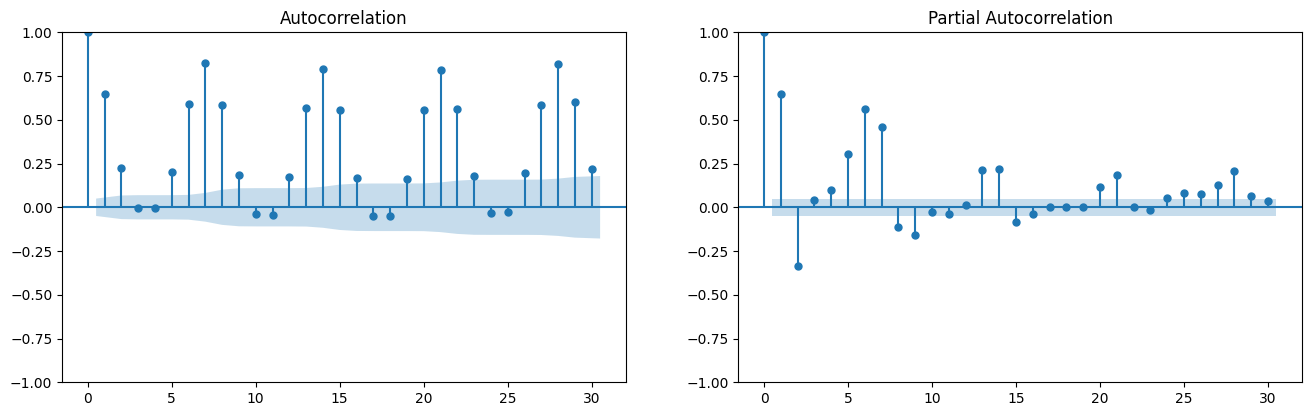

ACF e PACF para o estado: TX


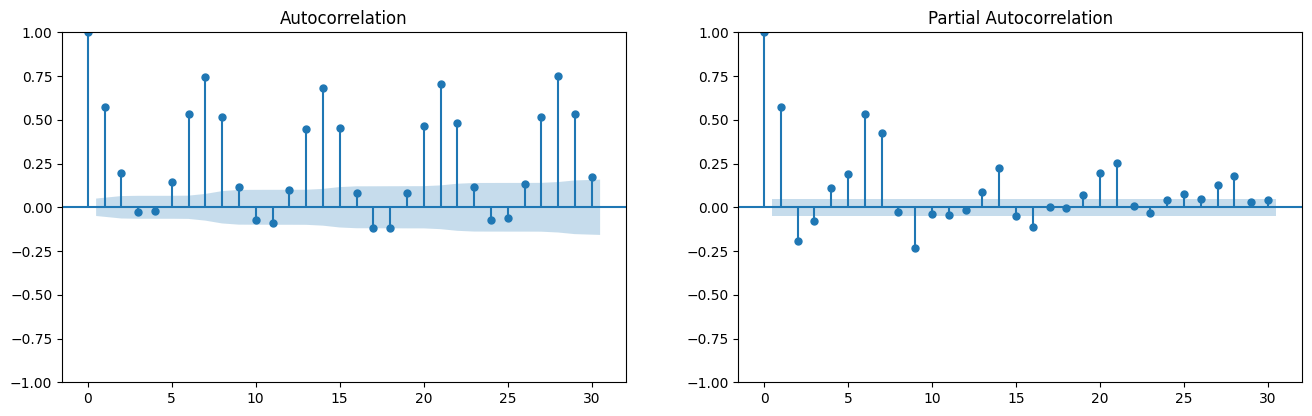

ACF e PACF para o estado: WI


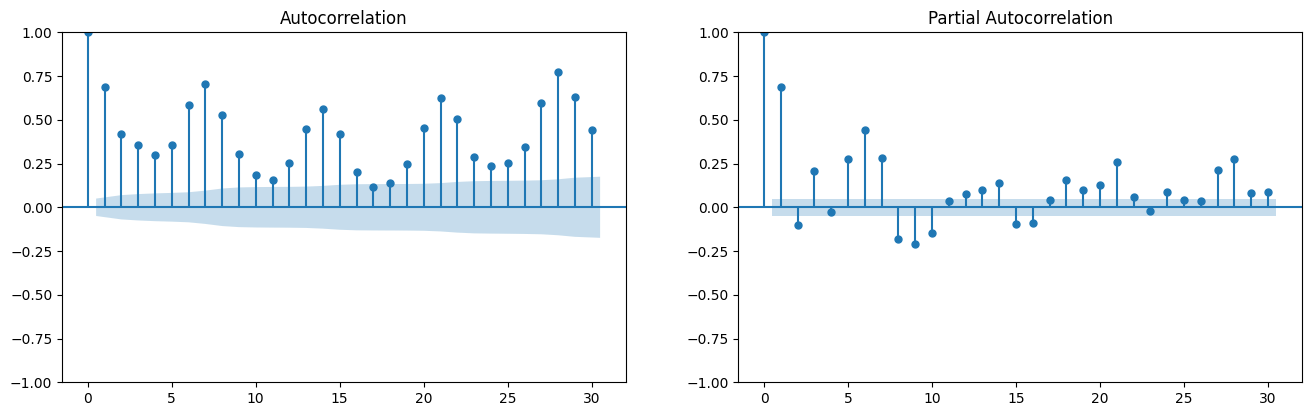

In [ ]:
for state in data_train['unique_id'].unique():
    state_df = data_train[data_train['unique_id'] == state]
    print(f"ACF e PACF para o estado: {state}")
    acf_pacf(state_df['y'], 30)

## Treinamento e previsão do modelo

In [ ]:
models = [
    RandomForestRegressor(n_estimators=50, random_state=0),
    KNeighborsRegressor(n_neighbors=3),
]

In [ ]:
mlf = MLForecast(
    models=models,
    freq='D',
    target_transforms=[LocalMinMaxScaler()],
    lags=[90]
)
mlf.fit(data_train)

MLForecast(models=[RandomForestRegressor, KNeighborsRegressor], freq=D, lag_features=['lag90'], date_features=[], num_threads=1)

In [ ]:
forecasts = mlf.predict(395)

In [ ]:
data_test = data_test.merge(forecasts, how='left', on=['unique_id', 'ds'])

In [ ]:
data_test

,unique_id,ds,y,RandomForestRegressor,KNeighborsRegressor
0,CA,2015-04-30,12985,14751.868164,14660.611328
1,CA,2015-05-01,17168,16773.529297,16420.248047
2,CA,2015-05-02,19497,16759.570312,18581.175781
3,CA,2015-05-03,20394,14569.185547,13316.812500
4,CA,2015-05-04,17031,14845.945312,13700.334961
...,...,...,...,...,...
1162,WI,2016-05-18,11043,11340.717773,10721.677734
1163,WI,2016-05-19,11504,11355.180664,11006.433594
1164,WI,2016-05-20,12819,12381.292969,11829.989258
1165,WI,2016-05-21,14734,10068.495117,10827.967773


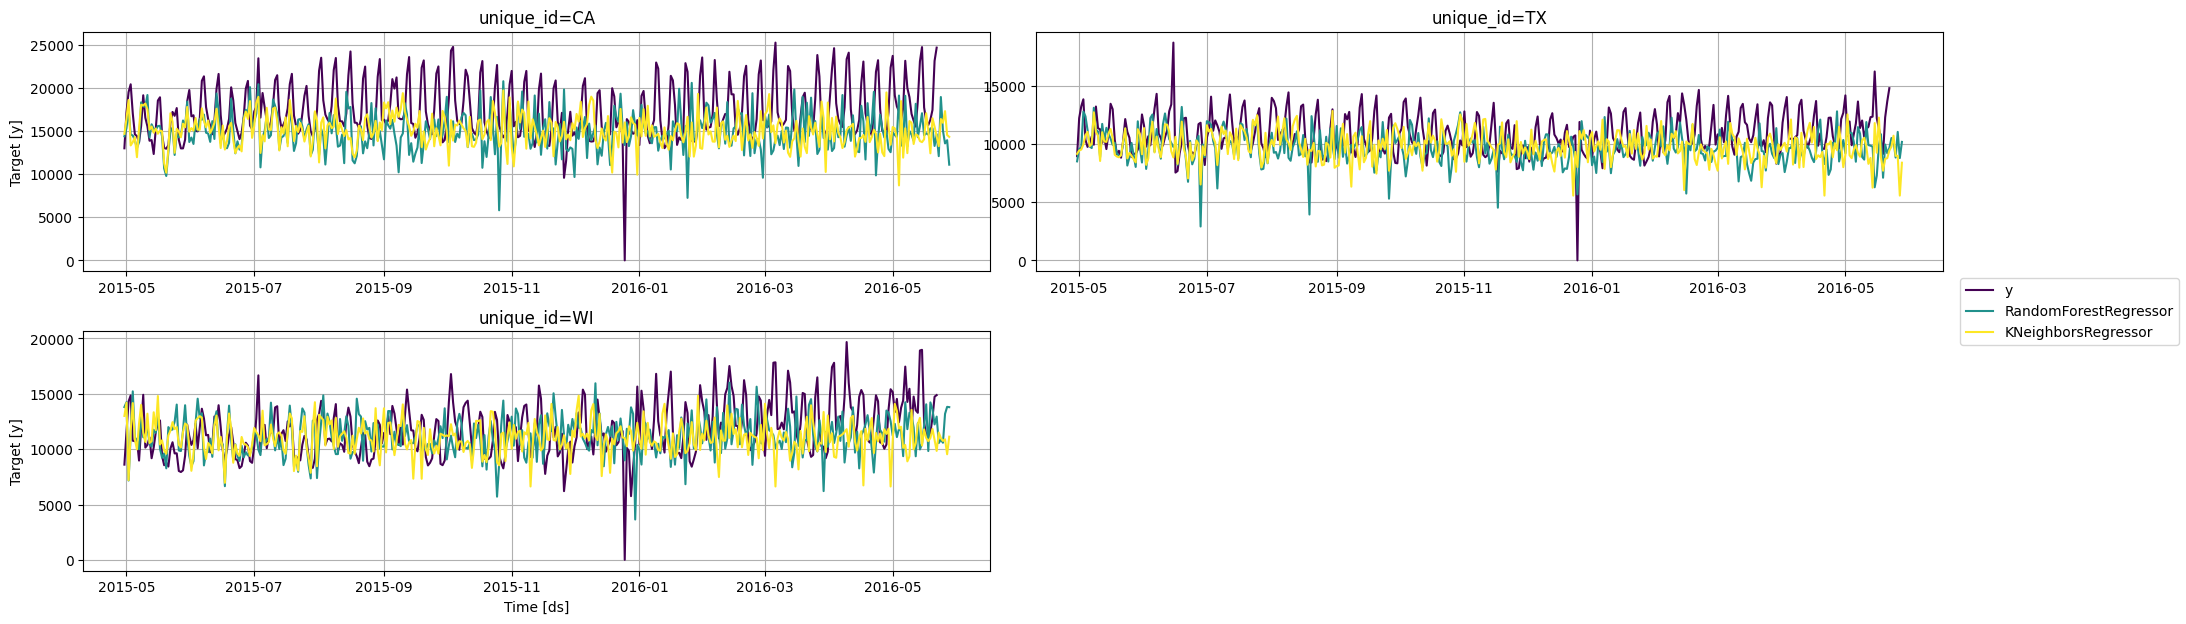

In [ ]:
plot_series(data_test, forecasts, plot_random=False)

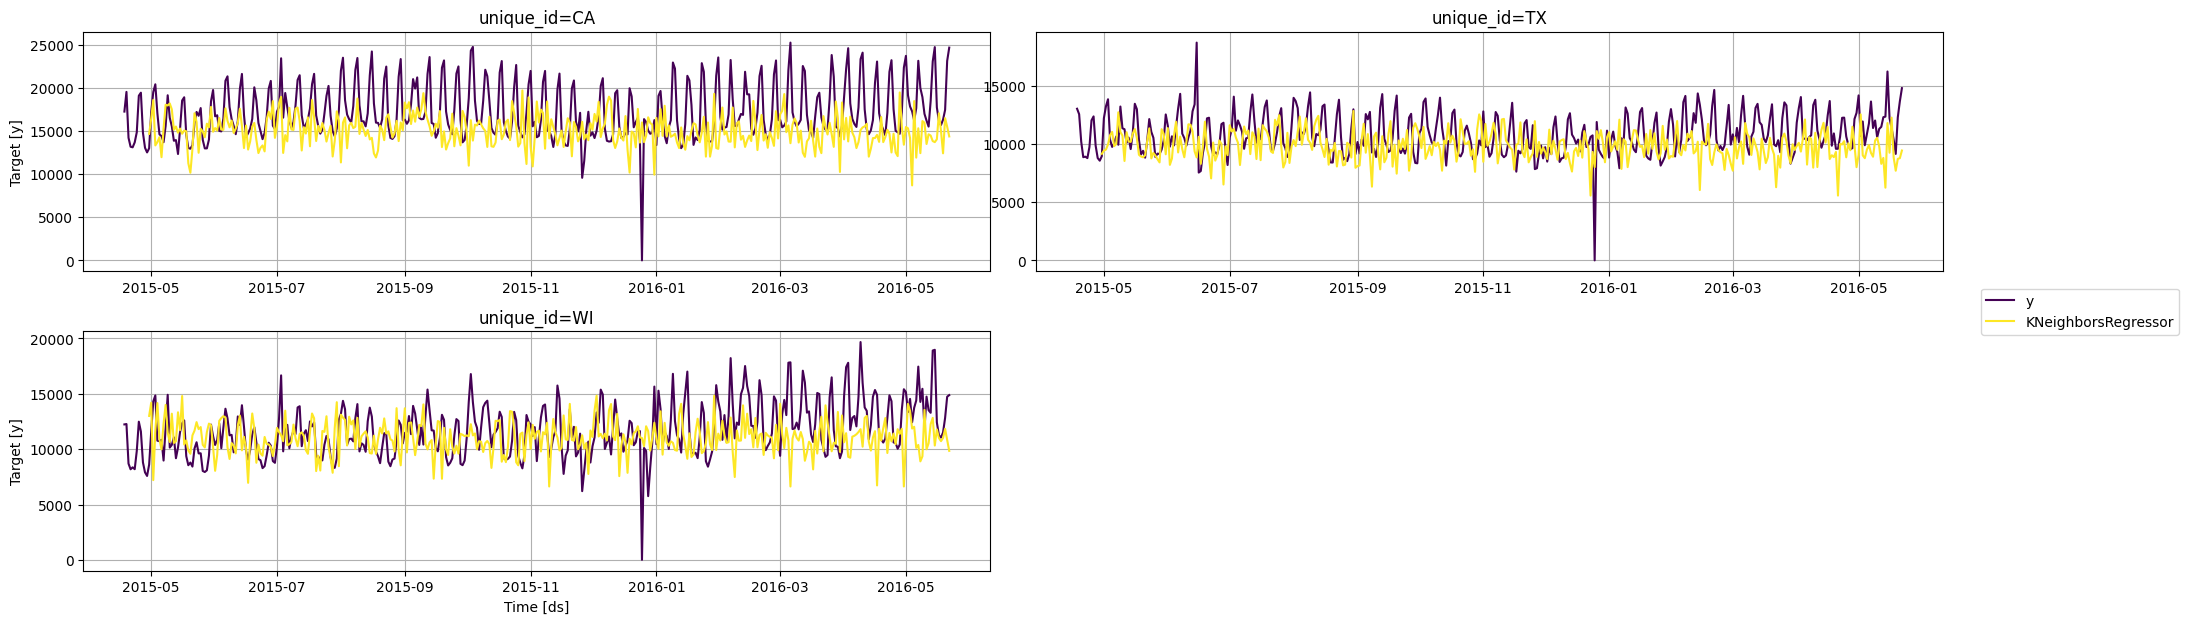

In [ ]:
fig = plot_series(
    data_train,
    data_test,
    plot_random=False,
    models=['KNeighborsRegressor'],
    max_insample_length=12
)
fig

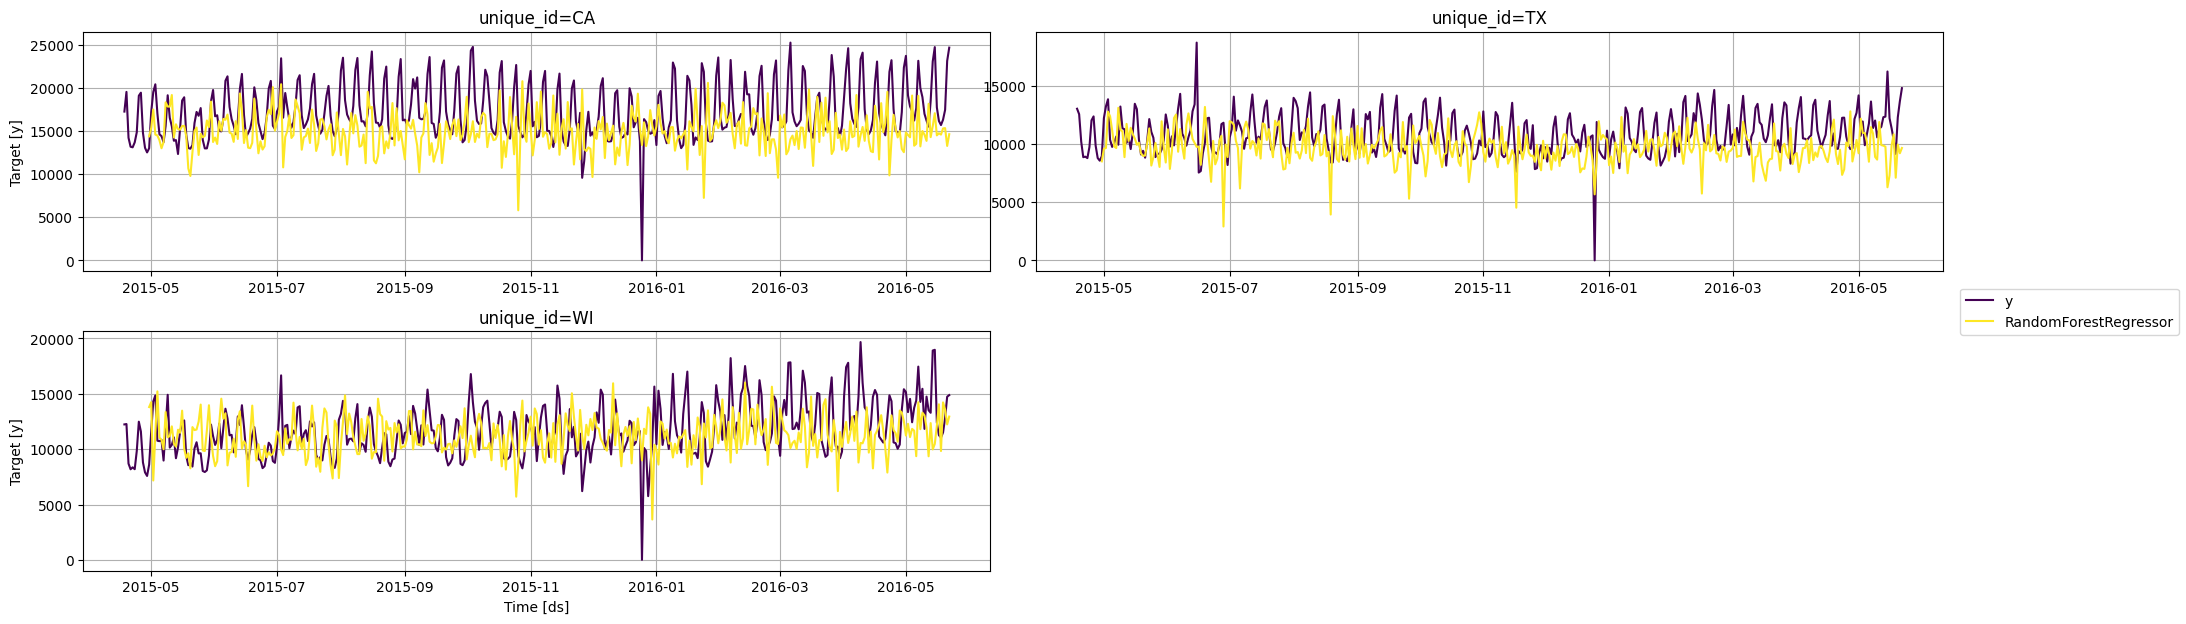

In [ ]:
fig = plot_series(
    data_train,
    data_test,
    plot_random=False,
    models=['RandomForestRegressor'],
    max_insample_length=12
)
fig

In [ ]:
metrics = []

# Calcular as métricas para cada unique_id
unique_ids = data_test['unique_id'].unique()
for unique_id in unique_ids:
    subset = data_test[data_test['unique_id'] == unique_id]
    y_true = subset['y']

    # Previsões do RandomForestRegressor
    y_pred_rf = subset['RandomForestRegressor']
    mae_rf = mean_absolute_error(y_true, y_pred_rf)
    mse_rf = mean_squared_error(y_true, y_pred_rf)
    r2_rf = r2_score(y_true, y_pred_rf)
    mape_rf = MAPE(y_true, y_pred_rf)

    # Previsões do KNeighborsRegressor
    y_pred_knn = subset['KNeighborsRegressor']
    mae_knn = mean_absolute_error(y_true, y_pred_knn)
    mse_knn = mean_squared_error(y_true, y_pred_knn)
    r2_knn = r2_score(y_true, y_pred_knn)
    mape_knn = MAPE(y_true, y_pred_knn)

    # Adicionar métricas ao dataframe
    metrics.append({
        'unique_id': unique_id,
        'MAE_RF': mae_rf,
        'MSE_RF': mse_rf,
        'R2_RF': r2_rf,
        'MAPE_RF': mape_rf,
        'MAE_KNN': mae_knn,
        'MSE_KNN': mse_knn,
        'R2_KNN': r2_knn,
        'MAPE_KNN': mape_knn
    })

# Criar um DataFrame com as métricas
metrics_df = pd.DataFrame(metrics)

# Exibir o DataFrame
metrics_df

,unique_id,MAE_RF,MSE_RF,R2_RF,MAPE_RF,MAE_KNN,MSE_KNN,R2_KNN,MAPE_KNN
0,CA,3349.800049,19779886.0,-1.020941,5.905030,3202.686768,18145024.0,-0.853904,7.013236
1,TX,1969.911621,6437082.5,-1.086825,3.819177,1878.435791,5804240.0,-0.881665,5.318682
2,WI,2305.504639,8889711.0,-0.565465,5.964306,2218.450928,8469253.0,-0.491423,7.250153


## Previsão 6 meses

In [ ]:
mlf_full = MLForecast(
    models=models,
    freq='D',
    target_transforms=[LocalMinMaxScaler()],
    lags=[90]
)
mlf_full.fit(data_full)

MLForecast(models=[RandomForestRegressor, KNeighborsRegressor], freq=D, lag_features=['lag90'], date_features=[], num_threads=1)

In [ ]:
previsao_6meses = mlf_full.predict(180)

In [ ]:
previsao_6meses

,unique_id,ds,RandomForestRegressor,KNeighborsRegressor
0,CA,2016-05-23,15600.531250,14666.512695
1,CA,2016-05-24,14238.525391,13898.388672
2,CA,2016-05-25,12672.618164,13372.284180
3,CA,2016-05-26,16809.882812,14667.000000
4,CA,2016-05-27,17372.466797,15636.226562
...,...,...,...,...
535,WI,2016-11-14,13726.932617,12944.732422
536,WI,2016-11-15,11564.732422,14348.686523
537,WI,2016-11-16,13448.177734,12666.374023
538,WI,2016-11-17,13425.391602,11494.081055


## Exportando pkl

In [ ]:
with open('ModelosPKL/vendas_Estado.pkl', 'wb') as f:
    pickle.dump(mlf_full, f)

## Exportando previsão 6 meses

In [ ]:
previsao_6meses.to_csv('Previsoes/previsao_vendas_estado.csv', index=False)